In [1]:
import numpy as np
from matplotlib import figure, gridspec,colors

import scanner_interpretation as scani

import healpy as hp

from matplotlib import colors,cm
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import visualization as vis

import dill

from gammapy.datasets import Datasets
from gammapy.data import DataStore,ObservationFilter

from pathlib import Path
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion, Regions



with open("pickles/mplets.pkl","rb") as f:
    mplets = dill.load(f)

nosource_mask = mplets.table["TEVCAT_DISTANCES_DEG"] >= 0.2
Nmin4_mask = mplets.table["Nmax"] >= 4
Nmin5_mask = mplets.table["Nmax"] >= 5
dt1sec_mask = mplets.table["dt"] <= 1e9
xgal_mask = np.abs(mplets.table["MEDIAN_GLAT"]) > 5

In [2]:
mymask = xgal_mask * nosource_mask
reduced = mplets.table[mymask]
obsids = reduced["OBS_ID"]

current_obs_index = 12000

hess1_datastore = DataStore.from_dir("$HESS1")
hess1u_datastore = DataStore.from_dir("$HESS1U")
myobs = hess1_datastore.get_observations([obsids[current_obs_index]])
phottable = myobs[0].events.table

run_dist = scani.sphere_dist(phottable["RA"].data, phottable["DEC"].data, reduced[current_obs_index]["MEDIAN_RA"], reduced[current_obs_index]["MEDIAN_DEC"])

In [27]:
len(np.unique(mplets.table["OBS_ID"]))/(len(hess1_datastore.obs_ids) + len(hess1u_datastore.obs_ids))

0.583625730994152

In [25]:
reduced[reduced["OBS_ID"]==50966]["MEDIAN_RA"].data[0]

136.46817016601562

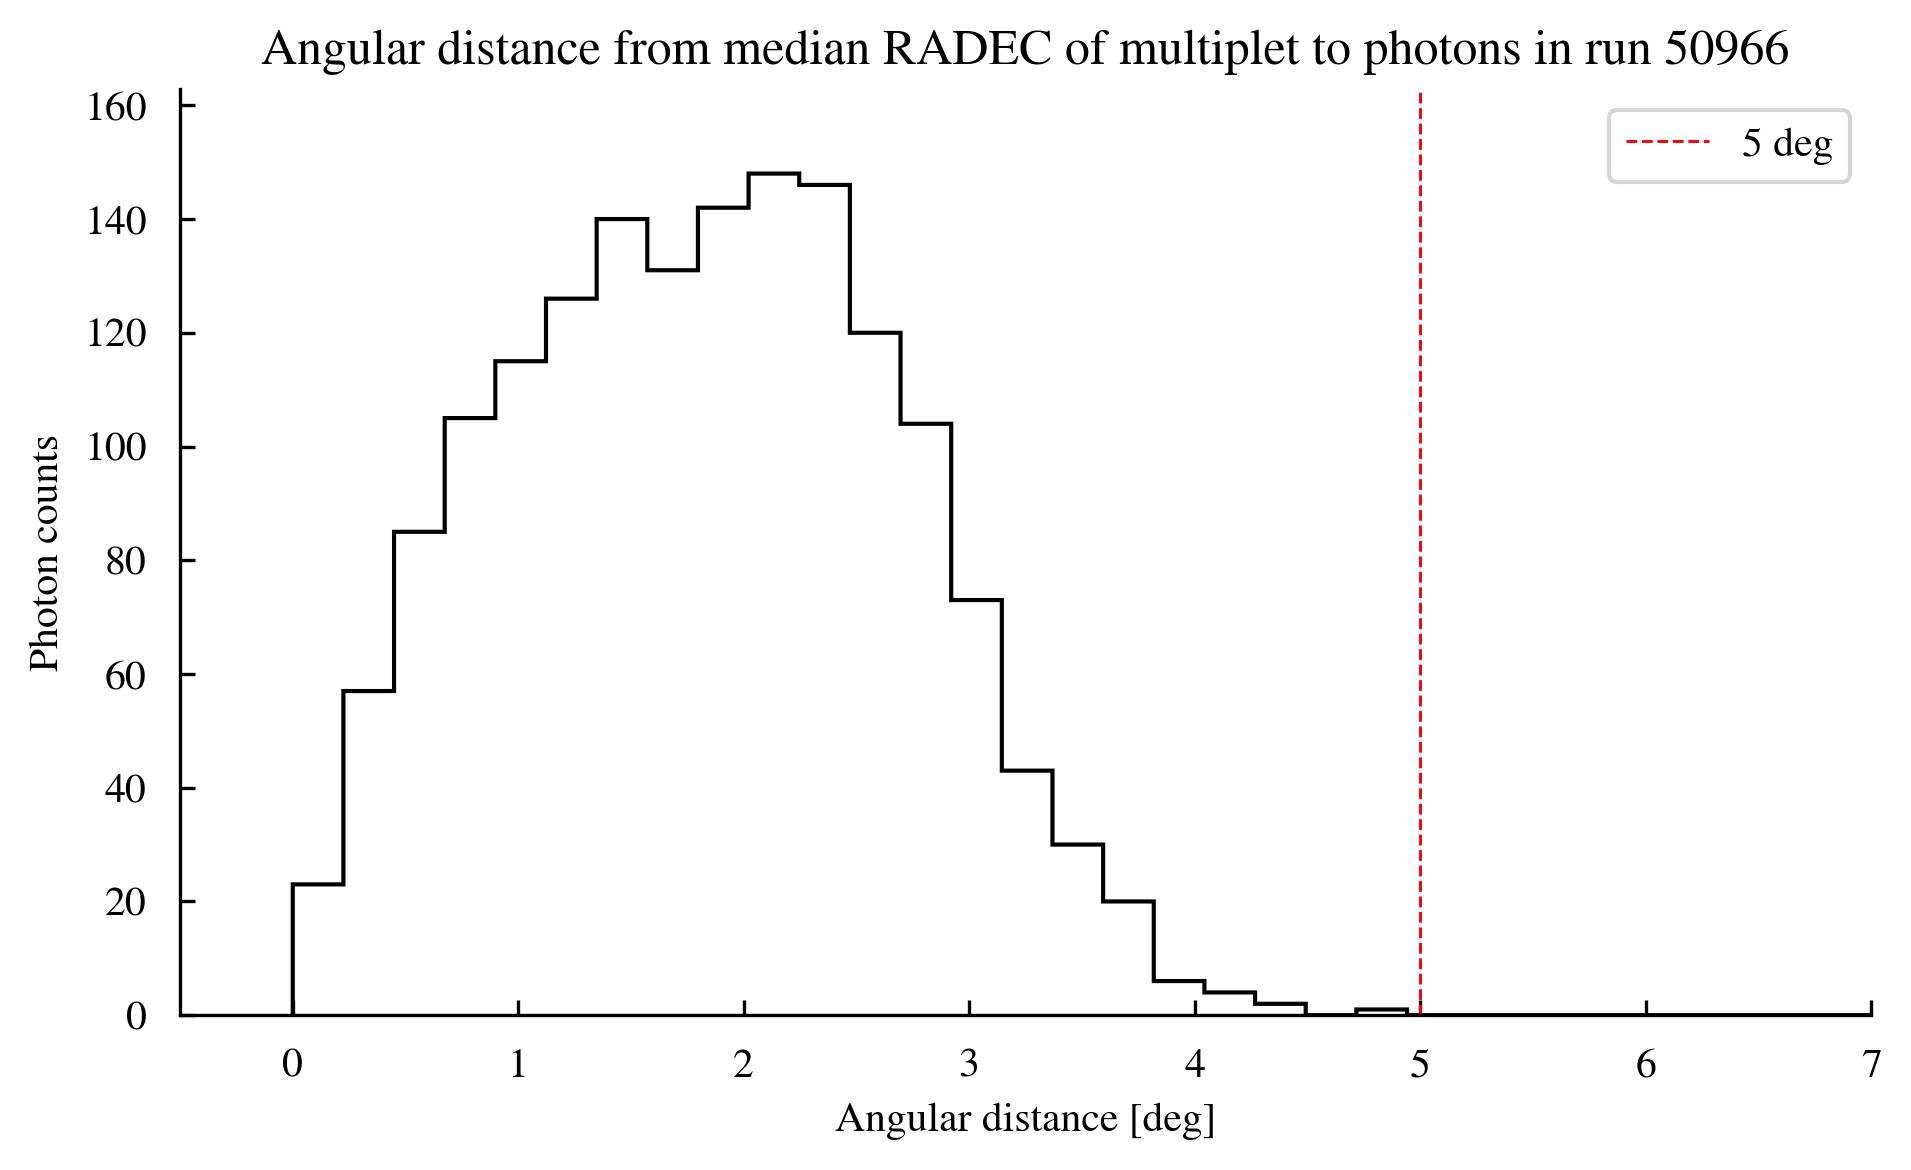

In [18]:
myhist = vis.hist(run_dist,histtype="step",bins="freedman")
plt.xlabel("Angular distance [deg]")
plt.ylabel("Photon counts")
plt.title(f"Angular distance from median RADEC of multiplet to photons in run {obsids[current_obs_index]}")
ax = plt.gca()
ylims = ax.get_ylim()
plt.vlines(5,ylims[0],ylims[1],color="red",ls="--",label="5 deg")
ax.set_ylim(*ylims)
ax.set_xlim(-.5,7)
plt.legend()
# plt.yscale("log")

In [13]:
myobs[0].obs_info["LIVETIME"]/60

28.15

In [14]:
mask = run_dist < 0.2
rate = len(phottable[mask][:])/myobs[0].obs_info["LIVETIME"]/60
rate

0.00017761989342806396

In [15]:
@np.vectorize
def in_which_container(item, c1, c2, out_c1=1, out_c2=2, out_neither=0):
    s1, s2 = set(c1), set(c2)
    if item in s1:
        return out_c1
    elif item in s2:
        return out_c2
    return out_neither

In [16]:
in_which_container([1,3,4],{5,1},{3,4})

array([1, 2, 2])

In [35]:
from astropy.table import Table
a = Table([[1,2,3],[4,5,6]],names=["a","b"])
for b in a:
    print(type(b["a"]))

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
